## LGT1 Unit 3 day 13 exercises

In today's exercises we look at the spectra of two Dirac operators; the Wilson Dirac operator and the overlap operator with the Wilson Dirac operator as a kernel. We should see clearly the difference in spectra between the two, the first having explicit chiral symmetry breaking, and the second being a solution to the Ginsparg-Wilson equation, effectively being a projection of the Wilson operator onto a chiral Dirac operator. 

The exercises are as follows, placed throughout the notebook:
 - plot the spectra of the Dirac operator on the complex plane - comment on the pattern you see
 - Show the overlap operator is a solution to the Ginsparg-Wilson equation
 - define the overlap operator from the deflated $H^2$ operator
 - comment on the shape of the eigenvalue plot for the overlap operator. How does it compare to the
   plot from the Wilson Dirac operator?

In [5]:
import gpt as g
import numpy as np
import matplotlib.pyplot as plt

In [7]:
grid = g.grid([8,8,8,16],g.double)

### Wilson Dirac operator spectra

We begin by analyzing the spectra of the Wilson Dirac operator. To start we look at the free case, where we set U to the identity at every site

In [8]:
U_f = g.qcd.gauge.unit(grid)
start = g.vspincolor(grid)

We will also look at the eigenvalues in the interacting case (optional), so below is a function to generate a single quenched configuration

In [32]:
def heatbath_quenched_config(L,Lt,beta):
    #create 1 config
    L = [L,L,L,Lt]
    grid = g.grid(L, g.single)
    grid_eo = g.grid(L, g.single, g.redblack)
    
    rng = g.random("test", "vectorized_ranlux24_24_64")
    U = g.qcd.gauge.unit(grid)
    Nd = len(U)
    
    # red/black mask
    mask_rb = g.complex(grid_eo)
    mask_rb[:] = 1
    # full mask
    mask = g.complex(grid)
    
    # simple plaquette action
    def staple(U, mu):
        st = g.lattice(U[0])
        st[:] = 0
        Nd = len(U)
        for nu in range(Nd):
            if mu != nu:
                st += g.qcd.gauge.staple(U, mu, nu) / U[0].otype.Nc
        return st
    
    g.default.push_verbose("su2_heat_bath", False)
    markov = g.algorithms.markov.su2_heat_bath(rng)
    U = g.qcd.gauge.unit(grid)
    plaquette_heatbath = []
    for it in range(150):
        plaq = g.qcd.gauge.plaquette(U)
        plaquette_heatbath.append(plaq)
        if it % 50 == 0:
            g.message(f"SU(2)-subgroup heatbath {it} has P = {plaq}")
        for cb in [g.even, g.odd]:
            mask[:] = 0
            mask_rb.checkerboard(cb)
            g.set_checkerboard(mask, mask_rb)
    
            for mu in range(Nd):
                st = g.eval(beta * staple(U, mu))
                markov(U[mu], st, mask)

    return U

In [37]:
U = heatbath_quenched_config(8,8,5.5)

GPT :    6373.905487 s : Initializing gpt.random(test,vectorized_ranlux24_24_64) took 0.000183344 s
GPT :    6374.032852 s : SU(2)-subgroup heatbath 0 has P = 1.0
GPT :    6381.186679 s : SU(2)-subgroup heatbath 50 has P = 0.5029050509134928
GPT :    6389.554543 s : SU(2)-subgroup heatbath 100 has P = 0.4927652147081163


From here, we want to calculate the eigenvalues. We initialize the Wilson Dirac operator, intialize a random fermion field for it to act on, then use the Arnoldi algorithm to calculate $N$ eigenvectors and eigenvalues. We only return the eigenvalues because we won't need to use the eigenvectors here. 

In [9]:
def compute_evs_Wilson(U,m):
    #operator init
    w = g.qcd.fermion.wilson_clover(U, mass=0.0, csw_r=0.0, csw_t=0.0, nu=1.0, xi_0=1.0,isAnisotropic=False,
                                    boundary_phases=[1,1,1,-1])

    #initialize random quark fields for the operator to act on
    start = g.vspincolor(w.F_grid)

    #define the implicitly restarted arnoldi eigenvector calculator. Nmin is the minimum amount of vectors we want, Nmax is a bigger
    #space of eigenvectors to look in, Nstop is where we would be fine with stopping, and resid is the accepted error
    g.default.set_verbose("arnoldi",False)
    a = g.algorithms.eigen.arnoldi(Nmin=700, Nmax=1400, Nstep=100,Nstop=500,resid=1e-6,implicit_restart=True)

    evec,evals = a(w,start)
    return evals

In [11]:
ev_wilson_free = compute_evs_Wilson(U_f,0.0)

EXERCISE: create a scatterplot of eigenvalues in the complex plane, and plot the GW circle. comment on the shape of the scatterplot. 

In [2]:
#plot Wilson Dirac spectra
fig1,ax1 = plt.subplots()

#create a scatterplot using the real and imaginary parts of the eigenvalues

#plot the GW circle, which is just a circle centered at 1 with radius 1 in this case

ax1.legend();

NameError: name 'plt' is not defined

Optional exercise: try this again for the interacting case, using a quenched configuration generated from the function at the beginning of the notebook

### Overlap operator spectra

For this part of the exercise, we are going to calculate the eigenvalues and eigenvectors of the overlap operator:
$$
D_{\text{ov}} = \frac{1}{a}(1 + \gamma_5\text{sign}[H]), \quad H = \gamma_5A
$$
for some general Hermitian kernel operator $H$. 

We will use the Wilson Dirac operator as $A$, thus $H = \gamma_5D_w(m = -M_5)$, where $M_5 = 1 + s$. This 'mass' parameter does not correspond to the mass of the fermion this operator describes,we are still working with massless fermions for any $M_5$.

EXERCISE: Show the general form of the overlap operator is a solution to the Ginsparg-Wilson equation,
$$
D\gamma_5 + \gamma_5D = aD\gamma_5D
$$

The overlap operator is gauge invariant and chirally symmetric, and its free of doublers because the kernel we are using is free of doublers, the Wilson Dirac operator. Any doubler free lattice Dirac operator can be used as the kernel, and the overlap operator will show these same properties. In this sense we can think of the overlap operator as a projection of a non-chiral doubler free lattice operator onto a chirally symmetric Dirac operator. 

Now we want to look at the spectrum of the overlap operator with the Wilson Dirac operator as its kernel. The tricky part is the evaluation of the Sign function, which acts by replacing all of the operator's eigenvalues by their sign. As a first step, we rewrite the sign function as 
$$
\text{Sign[H]} = \frac{H}{|H|} = \frac{H}{\sqrt{H^2}}
$$
The main issue here is how do we apply the $\sqrt{H^2}$ term to a given vector. We are first interested in looking at the spectrum of $H^2$. We pick $M_5 = 1.8$

In [16]:
w = g.qcd.fermion.wilson_clover(U_f, mass=-1.8, csw_r=0.0, csw_t=0.0, nu=1.0, xi_0=1.0,
                                isAnisotropic=False,boundary_phases=[1,1,1,-1])

#initialize random quark fields for the operator to act on
start = g.vspincolor(w.F_grid)
rng = g.random("evecs")
rng.normal(start)

#function that defines H^2
def H2(dst,src):
    dst @= g.gamma[5] * w * g.gamma[5] * w * src

#We use the arnoldi algorithm on the H^2 operator.
g.default.set_verbose("arnoldi",False)
a = g.algorithms.eigen.arnoldi(Nmin=700, Nmax=1400, Nstep=100, Nstop=500, resid=1e-6, implicit_restart=True)

evecH2, evalsH2 = a(H2,start)

GPT :    1153.891060 s : Initializing gpt.random(evecs,vectorized_ranlux24_389_64) took 0.000174522 s


Text(0, 0.5, 'eigenvalue of H^2')

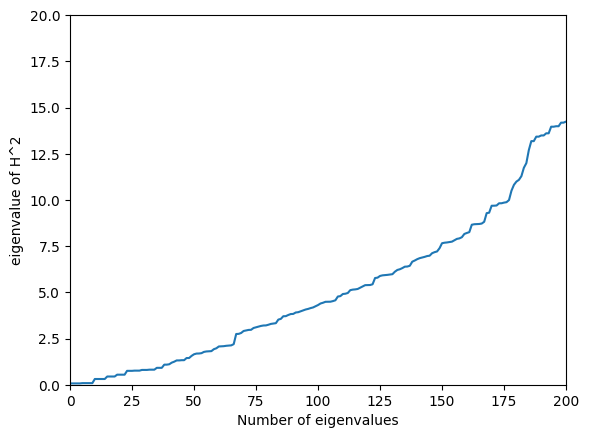

In [18]:
fig2,ax2 = plt.subplots()

ax2.plot(list(range(len(evalsH2))),sorted([e.real for e in evalsH2]))
ax2.set_xlim(0,200)
ax2.set_ylim(0,20)
ax2.set_xlabel("Number of eigenvalues")
ax2.set_ylabel("eigenvalue of H^2")

We clearly have some small eigenvalues. A common thing to do when evaluating the overlap operator is to define a deflated operator
$$
H^2_{\text{def}} = H^2 - \sum_n \lambda_n |n\rangle\langle n|
$$
with eigenvalues $\lambda_n$ and eigenvectors $|n\rangle$, and the sum running over the smallest eigenvalues up to a given threshold. 

We combine this small eigenmode subtraction with a polynomial approximation using Chebyshev polynomials. Chebyshev polynomials are defined in the interval $[-1,1]$, so we map the domain of eigenvalues into the domain of the Chebyshev polynomials. Then we expand the function in a truncated series,
$$
 r(x) \approx \sum_{n=0}^{N-1}c_nT_n(x)
$$
in our case, for the inverse square root function, for $\lambda \in [\alpha^2,\beta^2]$
$$
r(x) = \frac{1}{\sqrt{\lambda(x)}} = \left(\frac{1}{2}(\beta^2 + \alpha^2) + \frac{x}{2}(\beta^2 - \alpha^2)\right)^{-1/2}
$$
The coefficients are defined by
$$
c_n = \frac{\pi}{N}\sum_{k=1}^Nr(x_k)T_n(x_k),\quad x_k = \cos\left(\left(k-\frac{1}{2}\right)\frac{\pi}{N}\right)
$$
and the approximation of the sign function comes from multiplication by $H$
$$
\text{sign}[H] = \frac{H}{\sqrt{H^2}} = H\sum_{n=0}^{N-1}c_nT_n(X) + \mathcal{O}(\text{exp}(-2N|\alpha/\beta|))
$$
where 
$$
 X = \frac{2H^2 - (\beta^2 + \alpha^2)}{\beta^2 - \alpha^2}
$$

All of this is conviniently implemented in GPT, and we will use that here.

In [19]:
#with this, c(x) will approximate the function (x)^(-1/2) 
c = g.algorithms.polynomial.chebyshev(low=0.5,high=40,order=30,func=lambda x: x**-0.5)

In [27]:
#sorts the eigenvalues so we can subtract the smallest ones
idx = evalsH2.real.argsort()

#this function is our approximate inverse square root function in the overlap operator
def Hm0p5(dst,src):
    deflated_src = g.copy(src)
    dst[:] = 0
    for i in range(20):
        v = g.inner_product(evecH2[idx[i]],deflated_src)
        dst += evalsH2[idx[i]]**-0.5 * evecH2[idx[i]] * v
        deflated_src -= evecH2[idx[i]] * v
    dst += c(H2) * deflated_src #the return is the chebyshev approximation acting on the deflated field

#The form of these functions, F(dst,src) effectively acts the function on the 'src' argument, and returns
#it to the "dst" argument. So Hm0p5(dst,src) acts the sign function on src, and puts it in dst.

EXERCISE: define the overlap operator in the cell below using the following form of the overlap operator
$$
D_{\text{ov}} = \frac{1}{a}\left(1 + \gamma_5H(H^2)^{-1/2} \right), \quad H = \gamma_5A
$$

$$
D_{\text{ov}} = \frac{1}{a}\left(1 + A(\gamma_5A\gamma_5A)^{-1/2} \right)
$$
where $A$ is the Wilson Dirac operator with mass $M_5$

The Hm0p5 function above approximates the quantity in the inverse square root, so apply that function first, and complete the expression in the function below. 

In [28]:
#act the sign function above on 'src', then use the definition of the overlap
#operator above to fully define the function
def Overlap(dst,src):

    #act the above Hm0p5 on the passed in src
    dst @= #Fill this in - reminder, you can use the regular '*' operation for multiplication here due to how the operation is defined in GPT
    

SyntaxError: invalid syntax (3969584299.py, line 6)

Now with the overlap function defined, run the two cells below to calculate the eigenvalues and eigenvectors of the overlap operator using the Arnoldi algorithm, and plot the eigenvalues along with the GW circle in the complex plane. 

In [22]:
g.default.set_verbose("arnoldi", False)
a = g.algorithms.eigen.arnoldi(Nmin=300, Nmax=1400, Nstep=100, Nstop=200, resid=1e-6, implicit_restart=True)

evecOv, evalsOv = a(Overlap, start)

In [1]:
fig3, ax3 = plt.subplots()
ax3.scatter([e.real for e in evalsOv], [e.imag for e in evalsOv], label="Overlap (M5=-1.8, U=1)")
ax3.plot([1 - np.cos(phi) for phi in np.arange(0,2*np.pi,0.1)],[np.sin(phi) for phi in np.arange(0,2*np.pi,0.1)], c="red", label="GW circle")
ax3.legend()
ax3.set_xlim(-0.1,2.2)
ax3.set_ylim(-1.1,1.1)

NameError: name 'plt' is not defined

Optional exercise: Do this again with the quenched configuration generated at the beginning of this notebook